# Anexo A: Algoritmos para resolver sistemas de ecuaciones lineales implementados en Julia

## Paquetes

In [1]:
using LinearAlgebra, BenchmarkTools, Plots

## Métodos

Implementación del método de Jacobi.

In [2]:
function JacJul(
        A::Array{Float64,2},
        b::Array{Float64,1},
        x0::Array{Float64,1},
        e::Float64,
        itermax::Int64)
    
    #A:= Matriz de coeficientes
    #b:= vector de constantes
    #x0:= inicialización
    #e:= presicion
    #itermax:= iteración maxima
    
    #Iteración
    it::Int64 = 1
    
    #Matriz diagonal
    D::Array{Float64,2} = Diagonal(A)
    
    #Inversa de la matriz diagonal
    Dinv::Array{Float64,2} = inv(D)
    
    #Matriz triangular inferior
    L ::Array{Float64,2}= tril(A,-1)
    
    #Matriz triangular superior
    U::Array{Float64,2} = triu(A,1)
    
    #Iterando la solucion
    x::Array{Float64,1} = Dinv*(b- (L+U)*x0)
    
    #Calculando el residuo
    r::Array{Float64,1} = A*x-b
    
    #Normas de los residuos
    normresJAC::Array{Float64,1} = [norm(r)];
    
    #Repetir hasta el maximo numero de 
    #iteraciones o alcanzar la precision
    while ((normresJAC[it] > e) && (it <= itermax))      
        
        #Iterando la solucion
        x = Dinv*(b- (L+U)*x)
    
        #Calculando el residuo
        r = A*x-b
        
        #Normas de los residuos
        normresJAC = [normresJAC;norm(r)];
        
        #Aumentando la iteracion
        it = it + 1
        
    end
    
    return x, normresJAC
    
end;

Implementación de método de Sobre Relajación Sucesiva.

In [3]:
function SRSJul(
        A::Array{Float64,2},
        b::Array{Float64,1},
        x0::Array{Float64,1},
        w::Float64,
        e::Float64,
        itermax::Int64)
    
    #A:= Matriz de coeficientes
    #b:= vector de constantes
    #x0:= inicialización
    #w:= ponderador
    #e:= presicion
    #itermax:= iteración maxima
    
    #Iteración
    it::Int64 = 1

    #Matriz diagonal
    D::Array{Float64,2} = Diagonal(A)
    
    #Matriz triangular superior
    U::Array{Float64,2} = triu(A, 1)  
    
    #Matriz triangular inferior
    L::Array{Float64,2} = tril(A, -1)
    
    #alfa es una matriz auxiliar
    alfa::Array{Float64,2} = inv(w*L+D)
    
    #gama es un vector auxiliar
    gama::Array{Float64,1} = w*inv(D+w*L)*b
    
    #Iterando la solucion
    x::Array{Float64,1} = alfa*((1-w)*D*x0-w*U*x0) + gama
    
    #Calculando el residuo
    r::Array{Float64,1} = A*x-b
    
    #Normas de los residuos
    normresSCS::Array{Float64,1} = [norm(r)];
    
    #Repetir hasta el maximo numero de 
    #iteraciones o alcanzar la precision
    while ((normresSCS[it] > e) && (it <= itermax))    
        
        #Multiplicando
        x = alfa*((1-w)*D*x-w*U*x) + gama
    
        #Calculando la diferencia
        r = A*x-b
        
        #Normas de los residuos
        normresSCS = [normresSCS; norm(r)];

        #Aumentando la iteracion
        it = it + 1
    end
    
    return x, normresSCS
    
end;

Implementación de método de Gauss - Seidel.

In [4]:
function GSJul(
        A::Array{Float64,2},
        b::Array{Float64,1},
        x0::Array{Float64,1},
        e::Float64,
        itermax::Int64)
    
    #A:= Matriz de coeficientes
    #b:= vector de constantes
    #x0:= inicialización
    #e:= presicion
    #itermax:= iteración maxima
    
    #Iteración
    it::Int64 = 1
    
    #Matriz triangular inferior
    L::Array{Float64,2} = tril(A)
    
    #Matriz triangular superior
    U::Array{Float64,2} = triu(A,1)
    
    #Iterando la solucion
    x::Array{Float64,1} = inv(L)*(b-U*x0);
    
    #Calculando el residuo
    r::Array{Float64,1} = b-A*x
    
    #Normas de los residuos
    normresGAUSS::Array{Float64,1} = [norm(r)];
    
    #Repetir hasta el maximo numero de 
    #iteraciones o alcanzar la precision
    while ((normresGAUSS[it] > e) && (it <= itermax))      
        
        #Iterando la solucion
        x = inv(L)*(b-U*x);
        
        #Calculando el residuo
        r = b - A*x
        
        #Normas de los residuos
        normresGAUSS = [normresGAUSS;norm(r)];
        
        #Aumentando la iteracion
        it = it + 1
        
    end

    return x, normresGAUSS
end;

Implementación de método de gradiente conjugado.

In [5]:
function GCJul(
        A::Array{Float64,2},
        b::Array{Float64,1},
        x0::Array{Float64,1},
        e::Float64)
    
    #A:= Matriz de coeficientes
    #b:= vector de constantes
    #x0:= inicialización
    #e:= presicion    
    
    #Iteración
    it::Int64 = 1
    
    #numeq := numero de ecuaciones
    numeq::Int64 = size(A,1)
    
    #Iterando la solucion
    x::Array{Float64,1} = x0;
    
    #Calculando el residuo
    r::Array{Float64,1} = b - A*x
    
    #Vectores auxiliares
    d::Array{Float64,1} = r;
    s::Array{Float64,1} = r;
    
    #Normas de los residuos
    normresGC::Array{Float64,1} = [norm(r)];
    
    #Constantes auxiliares
    a::Float64 = 0.0
    beta::Float64 = 0.0
    
    #Por cada ecuacion, hacer lo siguiente:
    for k in 1:numeq
       
        #Si la norma del vector es mayor a 
        #la presicion entonces
        if normresGC[it] > e
           
            #a:= constante auxiliar
            a = r'r/(d'*A*d)
            
            #Iterando la solucion
            x = x + a*d
            
            #s:= vector auxiliar
            s = r - a*A*d
            
            #beta:= constante auxiliar
            beta = s's/r'r
            
            #d:= vector auxiliar
            d = s + beta*d
            
            #actualizando los residuos
            r = s
            
            #Normas de los residuos
            normresGC = [normresGC; norm(r)];

        else
            return  x, normresGC
        end
        
    end
    
    return x, normresGC
end;

## Ejemplo: 

#### Matriz de coeficientes (A)

In [6]:
A = [3.0 -1.0  0.0  0.0  0.0  0.5;
    -1.0  3.0 -1.0  0.0  0.5  0.0;
     0.0 -1.0  3.0 -1.0  0.0  0.0;
     0.0  0.0 -1.0  3.0 -1.0  0.0;
     0.0  0.5  0.0 -1.0  3.0 -1.0;
     0.5  0.0  0.0  0.0 -1.0  3.0;]

6×6 Array{Float64,2}:
  3.0  -1.0   0.0   0.0   0.0   0.5
 -1.0   3.0  -1.0   0.0   0.5   0.0
  0.0  -1.0   3.0  -1.0   0.0   0.0
  0.0   0.0  -1.0   3.0  -1.0   0.0
  0.0   0.5   0.0  -1.0   3.0  -1.0
  0.5   0.0   0.0   0.0  -1.0   3.0

#### Vector de constantes (b)

In [7]:
b = [5/2 3/2 1 1 3/2 5/2]
b = b[1,:]

6-element Array{Float64,1}:
 2.5
 1.5
 1.0
 1.0
 1.5
 2.5

#### Inicialización de la solución ($x_0$)

In [8]:
x0 = zeros(size(b))

6-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

#### Error máximo (e)

In [9]:
e = 0.000001

1.0e-6

#### Número máximo de iteraciones (itermax)

In [10]:
itermax  = 100

100

#### Solución

In [11]:
A\b

6-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### ****** Algoritmo de Jacobi ******

In [12]:
SolJac,histJac = JacJul(A,b,x0,e,itermax);

#### Solución

In [13]:
SolJac

6-element Array{Float64,1}:
 0.9999999976171963
 0.9999997813867877
 0.9999997976579562
 0.9999997976579562
 0.9999997813867877
 0.9999999976171963

#### Precisión vs Iteraciones

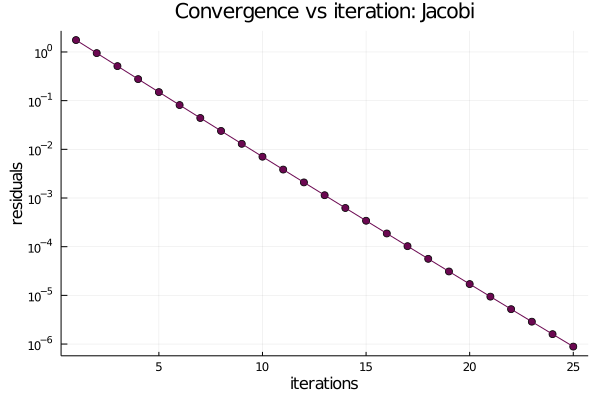

In [14]:
scatter(histJac, markersize=4, c="#6b0851", leg=false)
plot!(histJac, color="#6b0851", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence vs iteration: Jacobi")

### ****** Algoritmo de Sobre-Relajación ******

In [15]:
#Peso
w = 1.1;
SolSRS,histSRS = SRSJul(A,b,x0,w,e,itermax);

#### Solución

In [16]:
SolSRS

6-element Array{Float64,1}:
 1.0000001279675337
 0.9999999438723751
 0.9999997391036273
 0.999999769408286
 0.9999998817019154
 0.99999996097816

#### Precisión vs Iteraciones

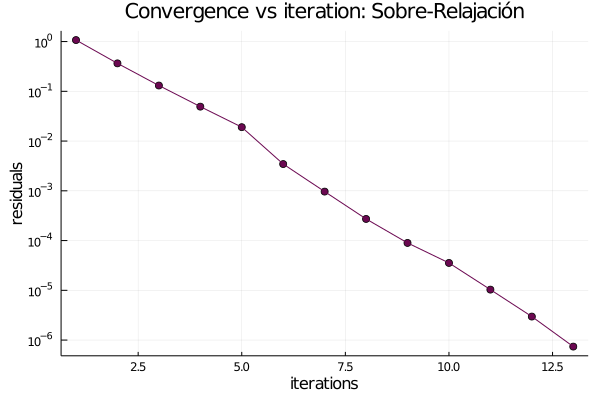

In [17]:
scatter(histSRS, markersize=4, c="#6b0851", leg=false)
plot!(histSRS, color="#6b0851", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence vs iteration: Sobre-Relajación")

### ******** Algoritmo de Gauss - Seidel ********

In [18]:
SolGS,histGS = GSJul(A,b,x0,e,itermax);

#### Solución

In [19]:
SolGS

6-element Array{Float64,1}:
 1.0000002137455963
 1.0000002688269807
 1.0000002052803891
 1.000000079328917
 0.9999999631217477
 0.9999999520829831

#### Precisión vs Iteraciones

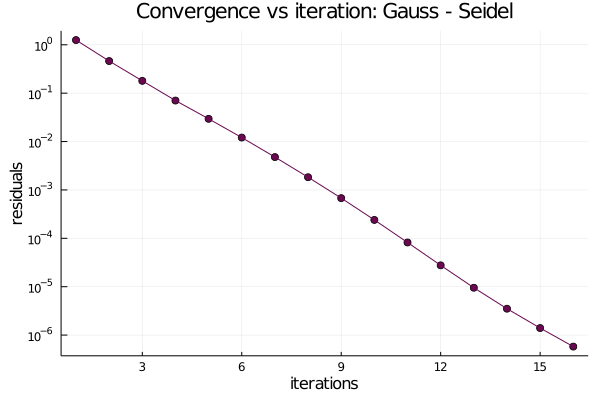

In [20]:
scatter(histGS, markersize=4, c="#6b0851", leg=false)
plot!(histGS, color="#6b0851", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence vs iteration: Gauss - Seidel")

### ******** Algoritmo del Gradiente Conjugado ********

In [21]:
SolGC,histGC = GCJul(A,b,x0,e);

#### Solución por el método de Gradiente Conjugado

In [22]:
SolGC

6-element Array{Float64,1}:
 1.0
 1.0
 0.9999999999999998
 0.9999999999999998
 1.0
 0.9999999999999999

##### Precisión vs Iteraciones

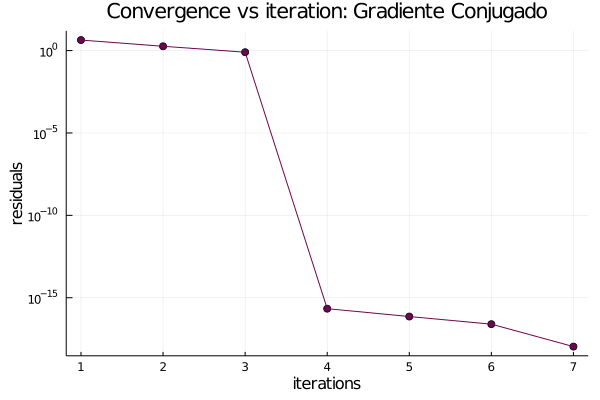

In [23]:
scatter(histGC, markersize=4, c="#6b0851", leg=false)
plot!(histGC, color="#6b0851", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence vs iteration: Gradiente Conjugado")